In [ ]:
%load_ext autoreload
%autoreload 2
from src.environments.rectangle import Rectangle
from src.environments.environment import RectangleEnv
from src.environments.optimizer import StepOptimizer
from src.models.agents import QLearningAgent, SarsaAgent
from src.models.trainer import Trainer
from src.models.agents_nstep import NStepQLearningAgent, NStepSarsaAgent
# from sanity_tests import *
import numpy as np
from src.utils.examples_gen import make_env_generator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.utils.scheduler import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
eps = ScheduleParam(1.0, LinearDecayRule(start=0.4, end=0.001, steps=1000))
alpha = ScheduleParam(1.0, LinearDecayRule(start=0.2, end=0.05, steps=1000))
c   = ScheduleParam(1.0, ExponentialDecayRule(start=1.0, gamma=0.999))

In [5]:
rect_params = dict(center=(0, 0), width=4.0, height=2.0, theta=np.pi/6)
optimizer_params = dict(loss="soft_l1", bounds=(-5, 5))

In [6]:
rect_params = dict(center=(0, 0), width=4.0, height=2.0, theta=np.pi/6)
optimizer_params = dict(loss="soft_l1", bounds=(-5, 5))

R = Rectangle(**rect_params)
x_lim = [-10, 10]
y_lim = [-10, 10]
points_params = dict(
    num_points=20,
    offset=(1, 1),
    rotation=np.pi / 6,
    jitter_t=0.05,
    jitter_n=0.01,
    rng=np.random.default_rng(42),
)

In [16]:
# check the generator and rendering
offset_range = ((-10, 10), (-10, 10))
env_generator = make_env_generator(
    rect_params, optimizer_params, points_params,
    offset_range=offset_range,
    rotation_range=(-np.pi/2, np.pi/2),
    x_lim=(-15, 15),
    y_lim=(-15, 15),
    rng=np.random.default_rng(0)
)
nA = len(env_generator().actions)

Using x_lim=(-15, 15), y_lim=(-15, 15) to accommodate offsets/rotations.


In [537]:
s1_agent = NStepSarsaAgent(nA=nA, alpha=alpha, eps=eps, c=c, n_step=1, policy="ucb")
s2_agent = NStepSarsaAgent(nA=nA, alpha=alpha, eps=eps, c=c, n_step=2)
s3_agent = NStepSarsaAgent(nA=nA, alpha=alpha, eps=eps, c=c, n_step=3)
q1_agent = NStepQLearningAgent(nA=nA, alpha=alpha, eps=eps, c=c, n_step=1, policy="ucb")

In [556]:
trainer = Trainer(envs=env_generator, agent=q1_agent, reuse_per_env=5)
trainer.fit(episodes=10000, log_interval=5)

In [539]:
q1_agent.eps

In [ ]:
env = env_generator()
metrices = trainer.evaluate(env, episodes=1)
# display(env.log)
display(metrices)
env.show_gif()

[{'original_dist': np.float64(6.685947240409679),
  'ep': 0,
  'reward': np.float64(10.019764115601388),
  'steps': 16,
  'optimizer_iters': 24}]

In [707]:
env.show_gif("archieve5.gif")

In [706]:
env.log

['State: (19, 0, 0, 1, 20, 0, 0)',
 "STEP 1 >>>>>> Action: ('move', ('up', 0.5)), Delta: 0.5, Old Dist: 8.1415",
 'State: (19, 0, 0, 1, 20, 0, 0)',
 'New Distance: 7.641510642500792',
 "STEP 2 >>>>>> Action: ('move', ('up', 0.5)), Delta: 0.5, Old Dist: 7.6415",
 'State: (19, 0, 0, 1, 20, 0, 0)',
 'New Distance: 7.141510708232306',
 "STEP 3 >>>>>> Action: ('move', ('up', 0.5)), Delta: 0.5, Old Dist: 7.1415",
 'State: (19, 0, 0, 1, 20, 0, 0)',
 'New Distance: 6.6415107821340795',
 "STEP 4 >>>>>> Action: ('move', ('up', 0.5)), Delta: 0.5, Old Dist: 6.6415",
 'State: (19, 0, 0, 1, 20, 0, 0)',
 'New Distance: 6.141510865830372',
 "STEP 5 >>>>>> Action: ('move', ('up', 0.5)), Delta: 0.5, Old Dist: 6.1415",
 'State: (19, 0, 0, 1, 20, 0, 0)',
 'New Distance: 5.641510961406535',
 "STEP 6 >>>>>> Action: ('move', ('up', 0.5)), Delta: 0.5, Old Dist: 5.6415",
 'State: (19, 0, 0, 1, 20, 0, 0)',
 'New Distance: 5.141511071585127',
 "STEP 7 >>>>>> Action: ('move', ('up', 0.5)), Delta: 0.5, Old Dist: 5

In [469]:
sum(sum(np.array(list(trainer.agent.Q.values())) != 0))

np.int64(64034)

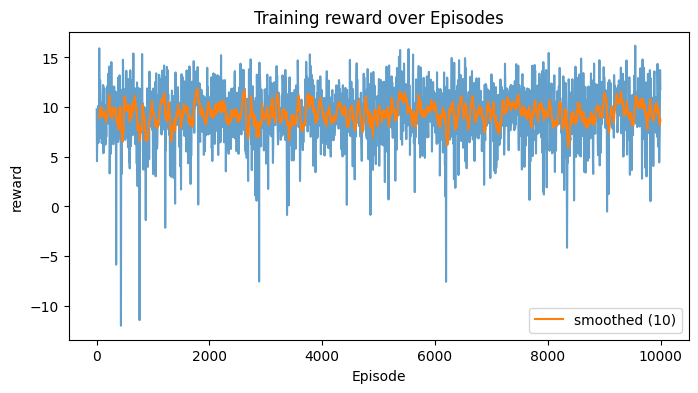

In [557]:
trainer.plot_training_logs(smooth_window=10)

In [ ]:
# --- evaluation ---
all_metrics = []
cur_max = 0

for _ in range(100):
    env = env_generator()
    metrics = trainer.evaluate(env, episodes=1)
    all_metrics.extend(metrics)
    # if metrics[0]['steps'] >= 20:
    #     break

In [343]:
env.show_gif()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- evaluation ---
all_metrics = []
agents = {
    "Q": q1_agent,
    "Sarsa1": s1_agent,
    "Sarsa2": s2_agent,
}

for agent_name, agent in agents.items():
    trainer = Trainer(envs=env_generator, agent=agent, reuse_per_env=3)
    # trainer.fit(episodes=10000, log_interval=5)
    for _ in range(100):
        env = env_generator()
        metrics = trainer.evaluate(env, episodes=3)
        # add agent name to each metric dict
        for m in metrics:
            m["agent"] = agent_name
        all_metrics.extend(metrics)
        if m['steps'] >= 50:
            env_copy = env

# put everything in a dataframe
df_all = pd.DataFrame(all_metrics)

# --- plotting ---
plt.figure(figsize=(8, 4))
sns.violinplot(data=df_all, x="agent", y="reward")
plt.title("Reward distribution across n-step Method")
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=df_all, x="agent", y="steps")
plt.title("Action steps across n-step Method")
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=df_all, x="agent", y="optimizer_iters")
plt.title("Optimizer iterations across n-step Method")
plt.show()


In [377]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_logs = []

for run_id in range(10):
    agent = NStepSarsaAgent(nA=nA, alpha=alpha, eps = eps, c=c,  n_step=2, policy = "ucb")  # reset agent
    trainer = Trainer(envs=env_generator, agent=agent, reuse_per_env=5)
    trainer.fit(episodes=10000, log_interval=5)

    df = pd.DataFrame(trainer.logs)
    df["run_id"] = run_id
    all_logs.append(df)
    print(f"Run {run_id} done")

df_all = pd.concat(all_logs, ignore_index=True)

Run 0 done
Run 1 done
Run 2 done
Run 3 done
Run 4 done
Run 5 done
Run 6 done
Run 7 done
Run 8 done
Run 9 done


In [390]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def plot_avg_metrics(df_all, cols, outdir="logs", prefix="q1"):
    ylims = {
        "reward": (-28, 20),
        "steps": (None, 74),      # "None" means auto for that bound
        "n_iters": (-35, 122),
    }

    for col in cols:
        plt.figure(figsize=(8, 4))
        sns.lineplot(
            data=df_all, x="ep", y=col,
            estimator="mean",
            errorbar="sd",
            alpha=0.7
        )
        plt.xlabel("Episode")
        plt.ylabel(col)
        plt.title(f"Average {col} over 10 runs")

        # apply y-limits if defined
        if col in ylims:
            plt.ylim(ylims[col])

        out_path = os.path.join(outdir, f"{prefix}_{col}.png")
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved {out_path}")


In [ ]:
plot_avg_metrics(df_all, cols=["reward", "steps", "n_iters"], outdir="logs", prefix="s2")